# **転移学習**
本章では転移学習と呼ばれる手法を紹介し，訓練済みのモデルを元にして，手元にある少量のデータを用いた画像分類モデルを構築する手法を示します．それに伴い，PyTorchが提供している主要な学習済みモデルのロード方法と，構築した自作モデルの保存と読み出しについても解説します．

## 転移学習とは
前章まででは，CIFAR-10の60,000枚の画像を使って10種類のクラス分類の画像認識モデルを構築し訓練を行いました．しかし実応用上は，自分がクラス分類を行いたいドメインの画像に対して，十分な量のデータセットを用意できるケースは稀でしょう．

一般にVGGやResNetといったImageNetなどの大規模画像データセットを使用して訓練を行った画像認識モデルでは，入力に近い層は画像のより抽象的な部分を，出力に近い層はドメインのより具体的な特徴にフォーカスした部分を見ていると言われており，このうち前者に関しては異なるドメインの画像に対しても有効な特徴抽出器として機能すると期待できます．そこで，学習済みモデルの最終出力層を自前のデータに対応した出力層に付け替え，付け替えた出力層への結合パラメータを手元にある少量のデータで訓練し直すことを考えます．このような手法を**転移学習（Transfer Learning）**と呼びます．

また，転移学習では入力層に近い部分の結合パラメータは訓練済みの値から変化させませんが，これらに関しても手元のデータを用いて訓練し直す場合の手法は**Fine Tuning**と呼びます．これに関しては後半で解説します．

本節では，VGG-16の訓練済みモデルをベースに，PyTorchの公式Tutorialで使用されているアリとハチの画像を分類するモデルを訓練します．

## 準備
以降を読み進めるにあたって，予め以下のパッケージをimportしておいてください．

In [1]:
# from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# random seed
import random
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

本章はCNNの訓練を行うので，CPUでの計算だとそれなりに時間がかかってしまいます．そこで，GPUを使用することで訓練を高速化しましょう．上のツールバーのRuntimeからChange runtime typeを選択して， Hardware acceleratorをGPUに設定します．また，PyTorchでのTensorの計算をGPUデバイス上で行うため，次のコードを実行してください．

In [2]:
# GPUの使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## データセットの作成
実験に使用するアリ🐜とハチ🐝の画像データセットを作成します．これらはそれぞれおよそ120枚の訓練データと75枚の検証データから成ります．これらはスクラッチからモデルを訓練するには非常に小さいデータセットですが，転移学習を用いることで性能の良いDNNモデルを実現することができます．

まずは，drive中にある画像ファイルの入ったzipファイルを解凍し，使用するデータのパスを読み込みましょう．

In [3]:
from google.colab import drive # driveを接続
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# drive中の課題ファイルのあるディレクトリに移動
%cd /content/drive/My Drive/Colab Notebooks/先端人工知能論I/20220607/data/transfer_learning
# zipファイルを解凍
!unzip hymenoptera_data.zip

/content/drive/My Drive/Colab Notebooks/先端人工知能論I/20220607/data/transfer_learning
Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train

In [5]:
data_dir = '/content/drive/My Drive/Colab Notebooks/先端人工知能論I/20220607/data/transfer_learning/hymenoptera_data'

データセットは`torchvision.datasets.ImageFolder`クラスを利用して簡単に作成することができます．これを使って例えば以下のような画像がクラスごとに別々のディレクトリに格納されているディレクトリを指定すると，各ディレクトリ名をラベルとして自動でラベル付けを行ったDatasetオブジェクトを生成することができます．

        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/xxz.png

        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/asd932_.png

また，この際予め画像に施しておくべき前処理を`torchvision.transforms.data_transforms`クラスのオブジェクトを引数とすることで指定できます．今回は．訓練時と検証時で異なる前処理を行っており，訓練時の前処理には`RandomResizedCrop`と`RandomHorizontalFlip`をかませることでデータ拡張を実施しています．

In [6]:
# 訓練時に使う画像にはデータ拡張と正規化を実施
# 検証時に使う画像に対しては正規化のみを実施
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# trainディレクトリとvalディレクトリそれぞれの中にある画像を使って訓練時と検証時それぞれのデータセットを作る
# さらにそれぞれantsとbeesディレクトリに分かれており，これらのラベルが振られる
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

訓練画像を可視化してどんな画像が含まれているのかチェックしておきましょう．

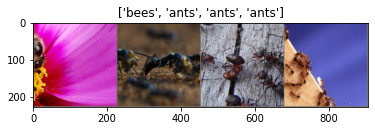

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# 訓練データをバッチごとに取り出す
# 詳しくは「画像分類機を訓練する」ノートブックのサンプルコードのコメントを見てください
inputs, classes = next(iter(dataloaders['train']))

# torchvision.utils.make_gridでバッチでまとまった複数の画像を，タイル状に並べた1枚の画像を表すTensorにできる
out = torchvision.utils.make_grid(inputs[0:4])

imshow(out, title=[class_names[x] for x in classes[0:4]])

## 学習済みモデルのロード
PyTorchでは，VGGやResNetなどいくつかの有名なモデルに関しては学習済みの状態でロードできるようになっています．本節では学習済みのVGG−16モデルをロードし使用することにしましょう．

In [8]:
# 訓練済みのVGG-16モデルをロード
use_pretrained = True # 訓練済みのパラメータを使用する
model = models.vgg16(pretrained=use_pretrained)

# 訓練モードに設定
model.train()
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

ここで，一番最後の(classifier)(6):Linearに注目すると，出力ユニットの数が1000となっており，VGG-16を訓練するのに用いたImageNetデータセットが1000種類のクラス分類用データセットであることがわかります．今回はアリとハチの2種類の画像を分類したいので，このclassifierモジュールの最後にある全結合層を付け替えることにしましょう．

In [9]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=2)
# GPUデバイスにモデルを移動
model = model.to(device)

## 損失関数・最適化手法の設定
ネットワークモデルの作成が完了したので，続いて損失関数を定義しましょう．今回の画像分類タスクは通常のクラス分類ですので，クロスエントロピー誤差を使用することにします．

In [10]:
criterion = nn.CrossEntropyLoss()

続いて最適化手法の設定ですが，今回の転移学習ではclassifierの最終層（付け替えた部分）のみを訓練したいので，それ以外の層では誤差逆伝播による勾配計算によってパラメータが更新されないように設定する必要があります．固定したいパラメータ`param`に対して`param.requires_grad=False`とすることでこれを行います．

In [13]:
params_to_update = []

update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# named_parameters()でnn.Moduleクラスオブジェクトの各層の重みパラメータを重みの名前（linear.weight, linear.biasなど）付きで取得できる
for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False

この上で，`params_to_update`だけを`optimizer`に渡します．

In [14]:
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

## 訓練の実行
ここまでの設定を用いて訓練を行います．

In [15]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # それぞれのエポックには訓練フェイズと検証フェイズがある
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # モデルを訓練モードに
            else:
                model.eval()  # モデルを検証モードに

            running_loss = 0.0  # 各バッチでのロスの累積和
            running_corrects = 0  # 各バッチでの正解数の累積和

            # 未学習時の検証性能を確かめるため，epoch=0の訓練はskip
            if (epoch == 0) and (phase == "train"):
                continue

            # dataloaderからバッチをとりだす
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) 
                labels = labels.to(device)

                # 各層の勾配をゼロに初期化
                optimizer.zero_grad()

                # forward
                # 訓練時のみ勾配計算を行う
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)  # 各バッチでのロスを累積
                running_corrects += torch.sum(preds == labels.data)  # 各バッチでの正解数を累積

            epoch_loss = running_loss / dataset_sizes[phase]  # エポック全体でのロスの平均
            epoch_acc = running_corrects.double() / dataset_sizes[phase]  # エポック全体での正解率

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 検証フェイズでもっとも正解率が高かったときの正解率とモデルの重みパラメータを保存
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # もっとも正解率が高かったときのモデルを返す
    model.load_state_dict(best_model_wts)
    return model

In [16]:
train_model(model, dataloaders, criterion, optimizer, num_epochs=25)

Epoch 1/25
----------
val Loss: 0.6334 Acc: 0.6405

Epoch 2/25
----------
train Loss: 0.4878 Acc: 0.7705
val Loss: 0.2035 Acc: 0.9477

Epoch 3/25
----------
train Loss: 0.2323 Acc: 0.9180
val Loss: 0.1322 Acc: 0.9477

Epoch 4/25
----------
train Loss: 0.1444 Acc: 0.9385
val Loss: 0.1197 Acc: 0.9542

Epoch 5/25
----------
train Loss: 0.1506 Acc: 0.9303
val Loss: 0.1077 Acc: 0.9542

Epoch 6/25
----------
train Loss: 0.1331 Acc: 0.9385
val Loss: 0.1063 Acc: 0.9542

Epoch 7/25
----------
train Loss: 0.1115 Acc: 0.9467
val Loss: 0.1038 Acc: 0.9542

Epoch 8/25
----------
train Loss: 0.1641 Acc: 0.9262
val Loss: 0.1017 Acc: 0.9542

Epoch 9/25
----------
train Loss: 0.1480 Acc: 0.9467
val Loss: 0.1023 Acc: 0.9412

Epoch 10/25
----------
train Loss: 0.1338 Acc: 0.9385
val Loss: 0.0967 Acc: 0.9542

Epoch 11/25
----------
train Loss: 0.1232 Acc: 0.9467
val Loss: 0.1101 Acc: 0.9412

Epoch 12/25
----------
train Loss: 0.0946 Acc: 0.9549
val Loss: 0.0947 Acc: 0.9608

Epoch 13/25
----------
train Los

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

訓練中に各epochでの訓練データと検証データそれぞれでのaccuracyを計算していますが，最初のepochでは未学習時（訓練済みのVGGモデルをそのまま用いた場合）のaccuracyを計算していることに注意してください．未学習の状態ではおおよそ50%程度のaccuracyであると思います．しかし訓練を続けていくとすぐにaccuracyは90%を超え，最終的には訓練データと検証データともに95%前後のaccuracyを得ることができました．入力に近い層で既に画像の一般的な特徴を捉えることはできているので，あとは出力に近い層を手元の訓練データに特化して調整し直すとそれなりに高い性能のモデルを得ることができる，ということがわかりました．

# Fine Tuning
前節までで扱った転移学習では出力層や出力層に近い部分以外のパラメータは固定しましたが，これらも含めて全層のパラメータを再学習させる手法は**Fine Tuning**と呼ばれます．ただし，Fine Tuningでは入力層に近い部分のパラメータは学習率を小さくし，出力層に近い部分のパラメータは学習率を大きく設定するのが一般的です．これは，入力に近い部分は特徴抽出器としてそれなりに仕上がっていることが期待されるので，あとは手元のデータセットによりフィットするように小さい学習率で微調整を図る，という考えによります．

またこの2つの手法を組み合わせることも可能です．つまり，訓練済みのモデルに対して，はじめは出力層以外は固定した状態で訓練を行い（転移学習），その後それらの固定を解除して全層での訓練を行う（Fine Tuning），という2段階のステップを踏むということです．そこで今回は，前節で訓練したVGGモデルをさらにFine Tuningで微調整していく，という実験に取り組むことにします．

基本的には転移学習でのコードをそのまま使い回せますが，出力層以外の層のパラメータに関しても勾配が計算されるように`requires_grad=True`にしておきます．また層ごとに学習率を変えたいので，学習率によって層をグループ分けしておきます．

In [18]:
# 設定する学習率によって層を3つにグループ分けする
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

for name, param in model.named_parameters():
  if update_param_names_1[0] in name:
    param.requires_grad = True
    params_to_update_1.append(param)
  
  elif name in update_param_names_2:
    param.requires_grad = True
    params_to_update_2.append(param)

  elif name in update_param_names_3:
    param.requires_grad = True
    params_to_update_3.append(param) 
  
  else:
    param.requires_grad = False

それではこれらの勾配を計算したいパラメータをoptimizerに渡してあげましょう．

In [19]:
optimizer_ft = optim.SGD([
                       {'params': params_to_update_1, 'lr': 1e-4},
                       {'params': params_to_update_2, 'lr': 5e-4},
                       {'params': params_to_update_3, 'lr': 1e-3},
], momentum=0.9)

訓練を行います．

In [20]:
train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=25)

Epoch 1/25
----------
val Loss: 0.0947 Acc: 0.9608

Epoch 2/25
----------
train Loss: 0.0947 Acc: 0.9549
val Loss: 0.0945 Acc: 0.9608

Epoch 3/25
----------
train Loss: 0.1053 Acc: 0.9631
val Loss: 0.0930 Acc: 0.9608

Epoch 4/25
----------
train Loss: 0.0847 Acc: 0.9795
val Loss: 0.0915 Acc: 0.9477

Epoch 5/25
----------
train Loss: 0.1015 Acc: 0.9467
val Loss: 0.0909 Acc: 0.9608

Epoch 6/25
----------
train Loss: 0.1138 Acc: 0.9508
val Loss: 0.0877 Acc: 0.9542

Epoch 7/25
----------
train Loss: 0.1101 Acc: 0.9467
val Loss: 0.0959 Acc: 0.9477

Epoch 8/25
----------
train Loss: 0.1229 Acc: 0.9549
val Loss: 0.0968 Acc: 0.9542

Epoch 9/25
----------
train Loss: 0.1216 Acc: 0.9385
val Loss: 0.0939 Acc: 0.9542

Epoch 10/25
----------
train Loss: 0.1013 Acc: 0.9590
val Loss: 0.0943 Acc: 0.9412

Epoch 11/25
----------
train Loss: 0.0936 Acc: 0.9631
val Loss: 0.0935 Acc: 0.9542

Epoch 12/25
----------
train Loss: 0.0673 Acc: 0.9754
val Loss: 0.0950 Acc: 0.9412

Epoch 13/25
----------
train Los

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# モデルの保存と読み出し
最後に，訓練したモデルを保存する方法を紹介します． PyTorchではモデルそのものを保存することは推奨されておらず，訓練したパラメータを辞書型変数として保存する方法が一般的です． 具体的には，ネットワークモデル変数`model`に対して，`model.state_dict()`でパラメータを辞書型変数として取り出し，`torch.save()`で保存します．

In [21]:
os.makedirs("params",exist_ok=True)
model_path = './params/model.pth'
torch.save(model.state_dict(), model_path)

保存したパラメータを読み出すには，`torch.load()`で辞書型オブジェクトを読み出し，保存時と同じ構造をもつネットワークモデル変数`model`に対して，`model.load_state_dict()`で呼び出したパラメータを格納します．

In [22]:
model_path = './params/model.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

ただし，GPUで学習したモデルをCPUで読み込みたい場合は注意が必要です．ナイーブな方法は，保存時に予め`model.to('cpu')`でモデルをcpuに移した上で保存しておくことでしょう．

In [23]:
model_path = './params/model.pth'
torch.save(model.to('cpu').state_dict(), model_path)

しかし，場合によっては自分ではなく他人がGPUモデルとして保存したパラメータをCPU上で読み出したい場合もあります．その場合には，`map_location`を使用することで対応することができます．

In [ ]:
model_path = './params/model.pth'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# 参考文献
[1] [TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) 

[2] 「つくりながら学ぶ！PyTorchによる発展ディープラーニング」 小川雄太郎、マイナビ出版